<a href="https://colab.research.google.com/github/QuocKhanhLuong/Scientific_Computing_2024.1/blob/main/2D_Heat_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

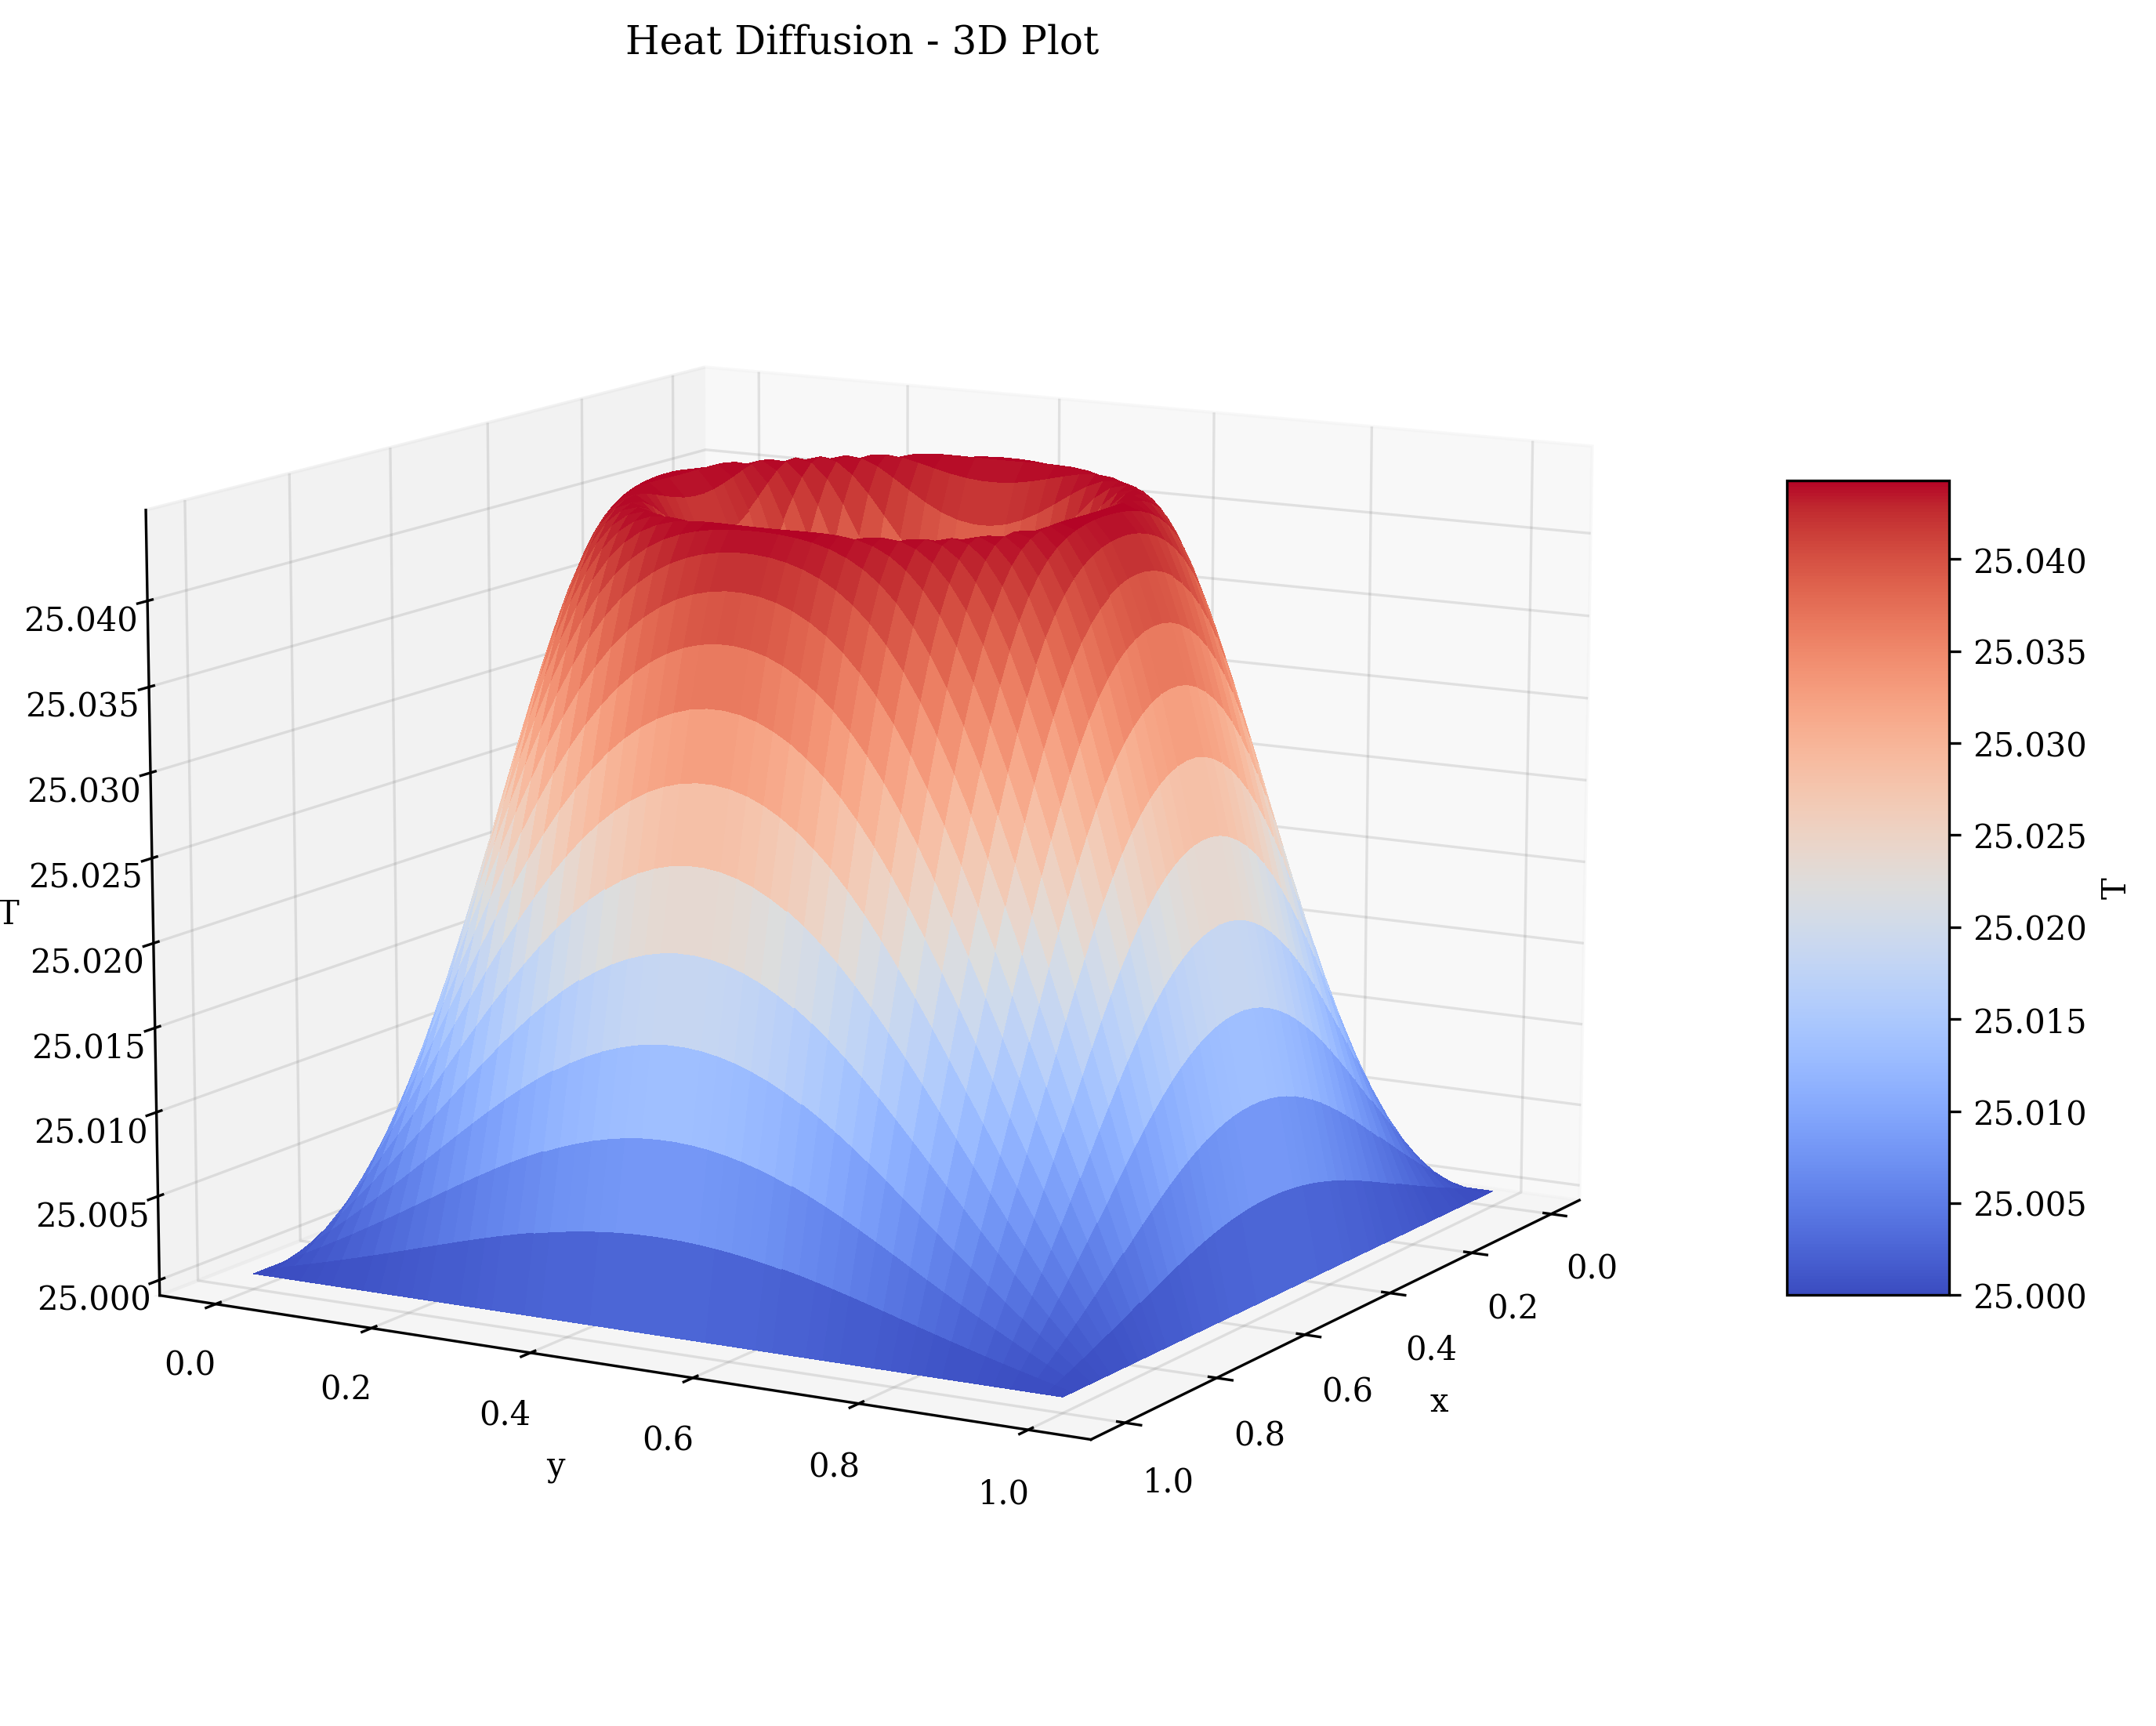

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter  # For animations
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import splu
from IPython.display import HTML, Image, clear_output # For displaying in Colab
import io
from PIL import Image as PILImage

# Set plotting styles (optional)
plt.style.use("default")
plt.rcParams['font.family'] = 'serif' # Or any other font available on your system
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.2)  # Grid settings

class HeatDiffusion:
    """
    Simulates 2D heat diffusion using finite difference methods.

    Args:
        L (float): Length of the simulation cell.
        R (float): Length of the inner square (heat source).
        D (float): Diffusion constant.
        dt (float): Time step size.
        N (int): Number of grid points in each direction.
        n (int): Number of time steps.
        T1 (float): Initial temperature at the boundary and at t=0.
        T2 (float): Temperature of the inner square (heat source).

    Attributes:
         h (float): Grid spacing.
         rho (ndarray): Temperature distribution at each time step (N x N x n).

    """
    def __init__(self, L, R, D, dt, N, n, T1, T2):
        self.L = L
        self.R = R
        self.D = D
        self.dt = dt
        self.N = N
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.h = L / (N - 1)
        self.rho = self.initialize()

    def initialize(self):
        """Creates the initial temperature distribution with boundary conditions."""
        rho = np.full((self.N, self.N, self.n), self.T1)  # Initialize with T1

        # Set inner region to T2. Using array slicing is faster than nested loops
        i_range = slice(int(self.N/2 - self.R/(2*self.h)), int(self.N/2 + self.R/(2*self.h)) + 1) # Added +1 for slice to get the correct length.
        j_range = slice(int(self.N/2 - self.R/(2*self.h)), int(self.N/2 + self.R/(2*self.h)) + 1)
        rho[i_range, j_range, 0] = self.T2

        return rho

    def explicit_euler(self):
        """Solves the heat equation using the explicit Forward Euler method."""
        cfl = self.D * self.dt / self.h**2
        if cfl > 0.25:
            raise ValueError(f"CFL condition violated: CFL={cfl:.2f} > 0.25. Reduce dt.")


        for t in range(self.n - 1):
            for i in range(1, self.N - 1):
                for j in range(1, self.N - 1):

                    if not (
                        (i * self.h >= self.L/2 - self.R/2) and (i * self.h <= self.L/2 + self.R/2) and
                        (j * self.h >= self.L/2 - self.R/2) and (j * self.h <= self.L/2 + self.R/2)
                    ): # Condition simplified.
                        self.rho[i, j, t + 1] = (
                            self.rho[i, j, t] +
                            (self.D * self.dt / self.h**2) * (
                                self.rho[i + 1, j, t] + self.rho[i - 1, j, t] +
                                self.rho[i, j + 1, t] + self.rho[i, j - 1, t] -
                                4 * self.rho[i, j, t]
                            )
                        )



    def implicit_euler(self):
        """Solves the heat equation using the implicit Backward Euler method."""

        M = lil_matrix((self.N**2, self.N**2))
        for i in range(self.N):
            for j in range(self.N):
                r = j * self.N + i
                if (1 <= i < self.N-1 and 1 <= j < self.N-1 and # Simplified inner condition and combined bound checking.
                        not (
                            (i * self.h >= self.L / 2 - self.R / 2) and (i * self.h <= self.L / 2 + self.R / 2) and
                            (j * self.h >= self.L / 2 - self.R / 2) and (j * self.h <= self.L / 2 + self.R / 2))
                       ):

                    M[r, r] = 1 + (4 * self.D * self.dt / self.h**2)
                    M[r, r + 1] = -self.D * self.dt / self.h**2
                    M[r, r - 1] = -self.D * self.dt / self.h**2
                    M[r, r + self.N] = -self.D * self.dt / self.h**2
                    M[r, r - self.N] = -self.D * self.dt / self.h**2

                else:
                    M[r, r] = 1



        M = csc_matrix(M)  # Convert to CSC format for efficient solving
        lu = splu(M)


        for t in range(self.n - 1):
            rho_flat = self.rho[:, :, t].flatten()
            self.rho[:, :, t + 1] = lu.solve(rho_flat).reshape(self.N, self.N)


    def plot_2D(self, id, t=0):
        """Creates a 2D contour plot of the temperature distribution at time t."""
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_title('Heat Diffusion - 2D Plot')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        X, Y = np.meshgrid(np.linspace(0, self.L, self.N), np.linspace(0, self.L, self.N))  # Corrected
        contour = ax.contourf(X, Y, self.rho[:, :, t], cmap=cm.coolwarm)
        cbar = fig.colorbar(contour, ax=ax, shrink=1.0, aspect=5)
        cbar.set_label('T')
        if not os.path.exists('images'):
            os.makedirs('images')
        fig.savefig(f'images/heat_diffusion_2D_{id}.png', dpi=300, bbox_inches="tight")  # Save
        plt.close(fig)  # Close to prevent display during simulation
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=300, bbox_inches="tight")
        buf.seek(0)
        image = PILImage.open(buf)
        clear_output(wait=True) #clear previous output. Prevents Colab from displaying multiple copies of the image.
        display(image)


    def plot_3D(self, id, t=0):
        """Creates a 3D surface plot of the temperature distribution at time t."""
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": "3d"})
        ax.set_title('Heat Diffusion - 3D Plot')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('T')
        ax.view_init(elev=12, azim=30)
        X, Y = np.meshgrid(np.linspace(0, self.L, self.N), np.linspace(0, self.L, self.N))  # Corrected

        surface = ax.plot_surface(X, Y, self.rho[:, :, t], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
        cbar.set_label('T')
        fig.savefig(f'images/heat_diffusion_3D_{id}.png', dpi=300, bbox_inches="tight")
        plt.close(fig) #close plot to prevent display during the simulation.
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=300, bbox_inches="tight")
        buf.seek(0)
        image = PILImage.open(buf)
        clear_output(wait=True) #clear previous output. Prevents Colab from displaying multiple copies of the image.
        display(image)


    def animation_2D(self, id):  # Use pre-calculated X, Y
        """Creates a 2D animation of the heat diffusion."""
        fig, ax = plt.subplots(figsize=(8, 7), dpi=200)
        X, Y = np.meshgrid(np.linspace(0, self.L, self.N), np.linspace(0, self.L, self.N))

        def animate(t):
            ax.clear()
            ax.set_title('Heat Diffusion - 2D Animation')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.contourf(X, Y, self.rho[:, :, 10*t], cmap=cm.coolwarm)  # Use 10*t for faster animation
            return []

        anim = FuncAnimation(fig, animate, frames=int(self.n / 10), blit=True, repeat=False, cache_frame_data=True) #Added blit=True and cache_frame_data to improve performance.
        anim.save(f'images/heat_diffusion_2D_{id}.gif', writer=PillowWriter(fps=20))
        plt.close(fig)
        # Convert animation to HTML for display in Colab
        clear_output(wait=True) #clear previous output
        plt.close(fig)
        with io.BytesIO() as gif:
            anim.save(gif, writer=PillowWriter(fps=20))
            gif.seek(0)
            display(HTML(f'<img src="data:image/gif;base64,{gif.read().encode("base64").decode()}" />'))

    def animation_3D(self, id):  # Use pre-calculated X, Y
        """Creates a 3D animation of the heat diffusion."""
        fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={"projection": "3d"}, dpi=200)
        X, Y = np.meshgrid(np.linspace(0, self.L, self.N), np.linspace(0, self.L, self.N))

        def animate(t):
            ax.clear()
            ax.set_title('Heat Diffusion - 3D Animation')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('T')
            ax.view_init(elev=12, azim=30)
            ax.plot_surface(X, Y, self.rho[:, :, 10*t], cmap=cm.coolwarm, linewidth=0, antialiased=False) #Use 10*t for faster animation.
            return []

        anim = FuncAnimation(fig, animate, frames=int(self.n / 10), blit=True, repeat=False, cache_frame_data=True) #Added blit=True and cache_frame_data to improve performance.

        anim.save(f'images/heat_diffusion_3D_{id}.gif', writer=PillowWriter(fps=20))
        plt.close(fig)
        clear_output(wait=True) #clear previous output.
        plt.close(fig)
        with io.BytesIO() as gif:
            anim.save(gif, writer=PillowWriter(fps=20))
            gif.seek(0)
            display(HTML(f'<img src="data:image/gif;base64,{gif.read().encode("base64").decode()}" />'))

# --- Example usage ---
L = 1.0
R = 0.2
D = 0.1
dt = 0.001
N = 50
n = 200
T1 = 25.0
T2 = 80.0

diffusion_sim = HeatDiffusion(L, R, D, dt, N, n, T1, T2)

# --- Plot Initial State ---
X, Y = np.meshgrid(np.linspace(0, L, N), np.linspace(0, L, N))
diffusion_sim.plot_2D('initial_2D', t=0) # Call before simulation
diffusion_sim.plot_3D('initial_3D', t=0) # Call before simulation

# Choose a method and run the simulation:
diffusion_sim.explicit_euler()  # or diffusion_sim.implicit_euler()

# --- Plot Final State ---
diffusion_sim.plot_2D('final_2D', t=n-1) #Call after simulation is complete
diffusion_sim.plot_3D('final_3D', t=n-1) #Call after simulation is complete


# Generate animations (optional – these will show the whole time evolution)
# diffusion_sim.animation_2D('2D_animation')
# diffusion_sim.animation_3D('3D_animation')